# Solar Irradiation Forecasting
## Task
The dataset contains such columns as: "Wind direction", "Wind speed", "Humidity" and Temperature. The response parameter that is to be predicted is: "Solar Radiation". It contains measurements for the past 4 months and you have to predict the level of solar radiation.

Solar Radiation has the highest correlation with the solar energy level, thus it is fundamental and crucial to be able to predict radiation properly. 

### Required dependencies are in environment.yml

### Alternatively, using the following commands will install them in an enviroment named solar-radiation

```
conda env create -f environment.yml

conda activate solar-radiation

jupyter lab

```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Data cleaning, formatting

In [2]:
solar = pd.read_csv('./data/SolarPrediction.csv')
solar.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [3]:
# Check if all values in data contain just date information
assert all(solar['Data'].str[-11:] == '12:00:00 AM')

In [4]:
# Remove irrelevant constant time
solar['Data'] = solar['Data'].str[:-11]
solar.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [5]:
# Format all datetime objects
solar['datetime'] = pd.to_datetime(solar['Data'] + solar['Time'])
solar['UNIXTime'] = pd.to_datetime(solar['UNIXTime'], unit='s')
solar['TimeSunRise'] = pd.to_datetime(solar['Data'] + solar['TimeSunRise'])
solar['TimeSunSet'] = pd.to_datetime(solar['Data'] + solar['TimeSunSet'])
solar = solar.drop(['Data', 'Time'], axis=1)
solar.head()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,datetime
0,2016-09-30 09:55:26,1.21,48,30.46,59,177.39,5.62,2016-09-29 06:13:00,2016-09-29 18:13:00,2016-09-29 23:55:26
1,2016-09-30 09:50:23,1.21,48,30.46,58,176.78,3.37,2016-09-29 06:13:00,2016-09-29 18:13:00,2016-09-29 23:50:23
2,2016-09-30 09:45:26,1.23,48,30.46,57,158.75,3.37,2016-09-29 06:13:00,2016-09-29 18:13:00,2016-09-29 23:45:26
3,2016-09-30 09:40:21,1.21,48,30.46,60,137.71,3.37,2016-09-29 06:13:00,2016-09-29 18:13:00,2016-09-29 23:40:21
4,2016-09-30 09:35:24,1.17,48,30.46,62,104.95,5.62,2016-09-29 06:13:00,2016-09-29 18:13:00,2016-09-29 23:35:24


In [6]:
# Ensure both timestamps are consistent
(solar['UNIXTime'] - solar['datetime']).nunique()

1

In [7]:
solar = solar.set_index('datetime')
solar = solar.drop('UNIXTime', axis=1)
solar.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
datetime,,,,,,,,
2016-09-29 23:55:26,1.21,48,30.46,59,177.39,5.62,2016-09-29 06:13:00,2016-09-29 18:13:00
2016-09-29 23:50:23,1.21,48,30.46,58,176.78,3.37,2016-09-29 06:13:00,2016-09-29 18:13:00
2016-09-29 23:45:26,1.23,48,30.46,57,158.75,3.37,2016-09-29 06:13:00,2016-09-29 18:13:00
2016-09-29 23:40:21,1.21,48,30.46,60,137.71,3.37,2016-09-29 06:13:00,2016-09-29 18:13:00
2016-09-29 23:35:24,1.17,48,30.46,62,104.95,5.62,2016-09-29 06:13:00,2016-09-29 18:13:00


In [8]:
solar.index.is_monotonic

False

In [9]:
solar = solar.sort_index()
solar['timedelta'] = pd.DataFrame(solar.index).diff()['datetime'].values
solar.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,timedelta
datetime,,,,,,,,,
2016-09-01 00:00:08,2.58,51,30.43,103,77.27,11.25,2016-09-01 06:07:00,2016-09-01 18:38:00,NaT
2016-09-01 00:05:10,2.83,51,30.43,103,153.44,9.00,2016-09-01 06:07:00,2016-09-01 18:38:00,00:05:02
2016-09-01 00:20:06,2.16,51,30.43,103,142.04,7.87,2016-09-01 06:07:00,2016-09-01 18:38:00,00:14:56
2016-09-01 00:25:05,2.21,51,30.43,103,144.12,18.00,2016-09-01 06:07:00,2016-09-01 18:38:00,00:04:59
2016-09-01 00:30:09,2.25,51,30.43,103,67.42,11.25,2016-09-01 06:07:00,2016-09-01 18:38:00,00:05:04


## Data Exploration

In [10]:
# Interval times are around 5min with some outliers
solar.describe()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,timedelta
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32685
mean,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,0 days 00:05:22.487165
std,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,0 days 00:24:58.144684
min,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,0 days 00:00:01
25%,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,0 days 00:04:58
50%,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,0 days 00:05:00
75%,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,0 days 00:05:02
max,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,2 days 14:24:49


In [11]:
print(np.sum(solar['timedelta'] <= pd.Timedelta('4min')))
print(np.sum(solar['timedelta'] >= pd.Timedelta('1h')))

12
17


In [12]:
# Look at data with smaller or larger than usual gaps

display(solar[solar['timedelta'] <= pd.Timedelta('4min')])
display(solar[solar['timedelta'] >= pd.Timedelta('1h')])

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,timedelta
datetime,,,,,,,,,
2016-09-16 07:40:16,216.68,51,30.45,99,66.26,14.62,2016-09-16 06:10:00,2016-09-16 18:25:00,00:00:01
2016-09-17 13:20:34,780.30,60,30.47,90,64.71,9.00,2016-09-17 06:10:00,2016-09-17 18:24:00,00:00:06
2016-09-29 11:15:22,1002.89,63,30.47,33,32.74,6.75,2016-09-29 06:13:00,2016-09-29 18:13:00,00:03:26
2016-09-29 15:05:23,744.43,61,30.43,50,1.60,5.62,2016-09-29 06:13:00,2016-09-29 18:13:00,00:03:13
2016-10-11 08:20:21,505.70,58,30.45,68,59.79,4.50,2016-10-11 06:16:00,2016-10-11 18:03:00,00:03:21
2016-10-17 11:25:17,979.37,64,30.47,26,32.64,9.00,2016-10-17 06:18:00,2016-10-17 17:58:00,00:03:24
2016-10-17 12:20:17,994.61,64,30.45,41,65.92,2.25,2016-10-17 06:18:00,2016-10-17 17:58:00,00:03:40
2016-11-03 17:00:22,126.42,63,30.41,32,30.05,3.37,2016-11-03 06:25:00,2016-11-03 17:47:00,00:03:12
2016-11-11 17:55:02,2.03,56,30.46,63,122.39,5.62,2016-11-11 06:29:00,2016-11-11 17:44:00,00:03:57


,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,timedelta
datetime,,,,,,,,,
2016-09-07 11:55:23,1075.35,58,30.44,82,10.55,7.87,2016-09-07 06:08:00,2016-09-07 18:33:00,0 days 01:15:02
2016-09-07 12:55:23,1069.20,59,30.43,80,1.88,4.50,2016-09-07 06:08:00,2016-09-07 18:33:00,0 days 01:00:00
2016-09-07 14:45:24,864.37,62,30.41,66,24.06,9.00,2016-09-07 06:08:00,2016-09-07 18:33:00,0 days 01:04:58
2016-09-07 17:50:22,100.84,57,30.41,82,72.85,5.62,2016-09-07 06:08:00,2016-09-07 18:33:00,0 days 01:05:02
2016-09-08 10:30:24,970.12,57,30.44,72,32.63,1.12,2016-09-08 06:09:00,2016-09-08 18:32:00,0 days 03:40:01
2016-09-08 11:35:21,490.29,57,30.44,76,2.69,3.37,2016-09-08 06:09:00,2016-09-08 18:32:00,0 days 01:04:57
2016-09-08 14:20:21,611.70,55,30.40,94,32.83,5.62,2016-09-08 06:09:00,2016-09-08 18:32:00,0 days 02:45:00
2016-09-08 18:10:22,15.64,50,30.39,100,57.48,3.37,2016-09-08 06:09:00,2016-09-08 18:32:00,0 days 02:19:57
2016-09-09 07:55:22,211.96,50,30.40,90,107.44,4.50,2016-09-09 06:09:00,2016-09-09 18:31:00,0 days 01:35:01


,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000


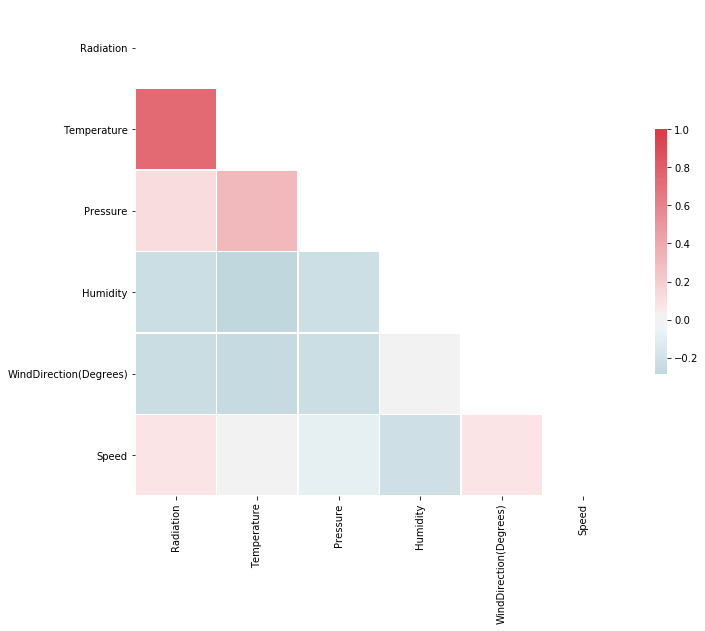

In [13]:
# Correlation between variables, as expected, temperature has the highest correlation with radiation
# Reference code: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

corr = solar.corr()
display(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [14]:
# Might be more useful to see correlation with previous time period
lagged_solar = solar.shift(1)
lagged_solar['New Radiation'] = solar['Radiation']
display(lagged_solar.head())

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,timedelta,New Radiation
datetime,,,,,,,,,,
2016-09-01 00:00:08,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,2.58
2016-09-01 00:05:10,2.58,51.0,30.43,103.0,77.27,11.25,2016-09-01 06:07:00,2016-09-01 18:38:00,NaT,2.83
2016-09-01 00:20:06,2.83,51.0,30.43,103.0,153.44,9.00,2016-09-01 06:07:00,2016-09-01 18:38:00,00:05:02,2.16
2016-09-01 00:25:05,2.16,51.0,30.43,103.0,142.04,7.87,2016-09-01 06:07:00,2016-09-01 18:38:00,00:14:56,2.21
2016-09-01 00:30:09,2.21,51.0,30.43,103.0,144.12,18.00,2016-09-01 06:07:00,2016-09-01 18:38:00,00:04:59,2.25


,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,New Radiation
Radiation,1.000000,0.734957,0.118990,-0.226168,-0.230310,0.073644,0.959799
Temperature,0.734957,1.000000,0.311121,-0.285055,-0.259392,-0.031420,0.727002
Pressure,0.118990,0.311121,1.000000,-0.223971,-0.228980,-0.083606,0.124577
Humidity,-0.226168,-0.285055,-0.223971,1.000000,-0.001839,-0.211631,-0.227398
WindDirection(Degrees),-0.230310,-0.259392,-0.228980,-0.001839,1.000000,0.073073,-0.227416
Speed,0.073644,-0.031420,-0.083606,-0.211631,0.073073,1.000000,0.072946
New Radiation,0.959799,0.727002,0.124577,-0.227398,-0.227416,0.072946,1.000000


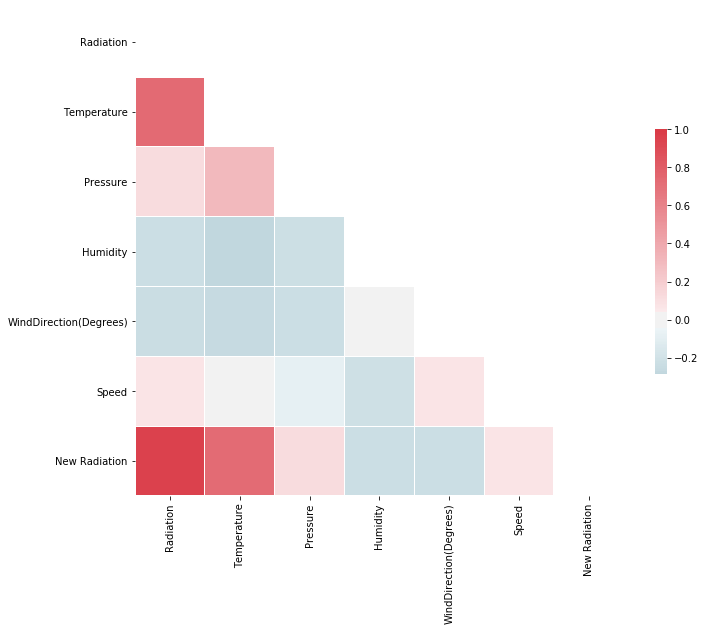

In [15]:
# Correlation between temperature and Radiation is still strong, but 1 step autocorrelation still seems to be more important, Wind speed seems to
# Reference code: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

corr = lagged_solar.corr()
display(corr)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

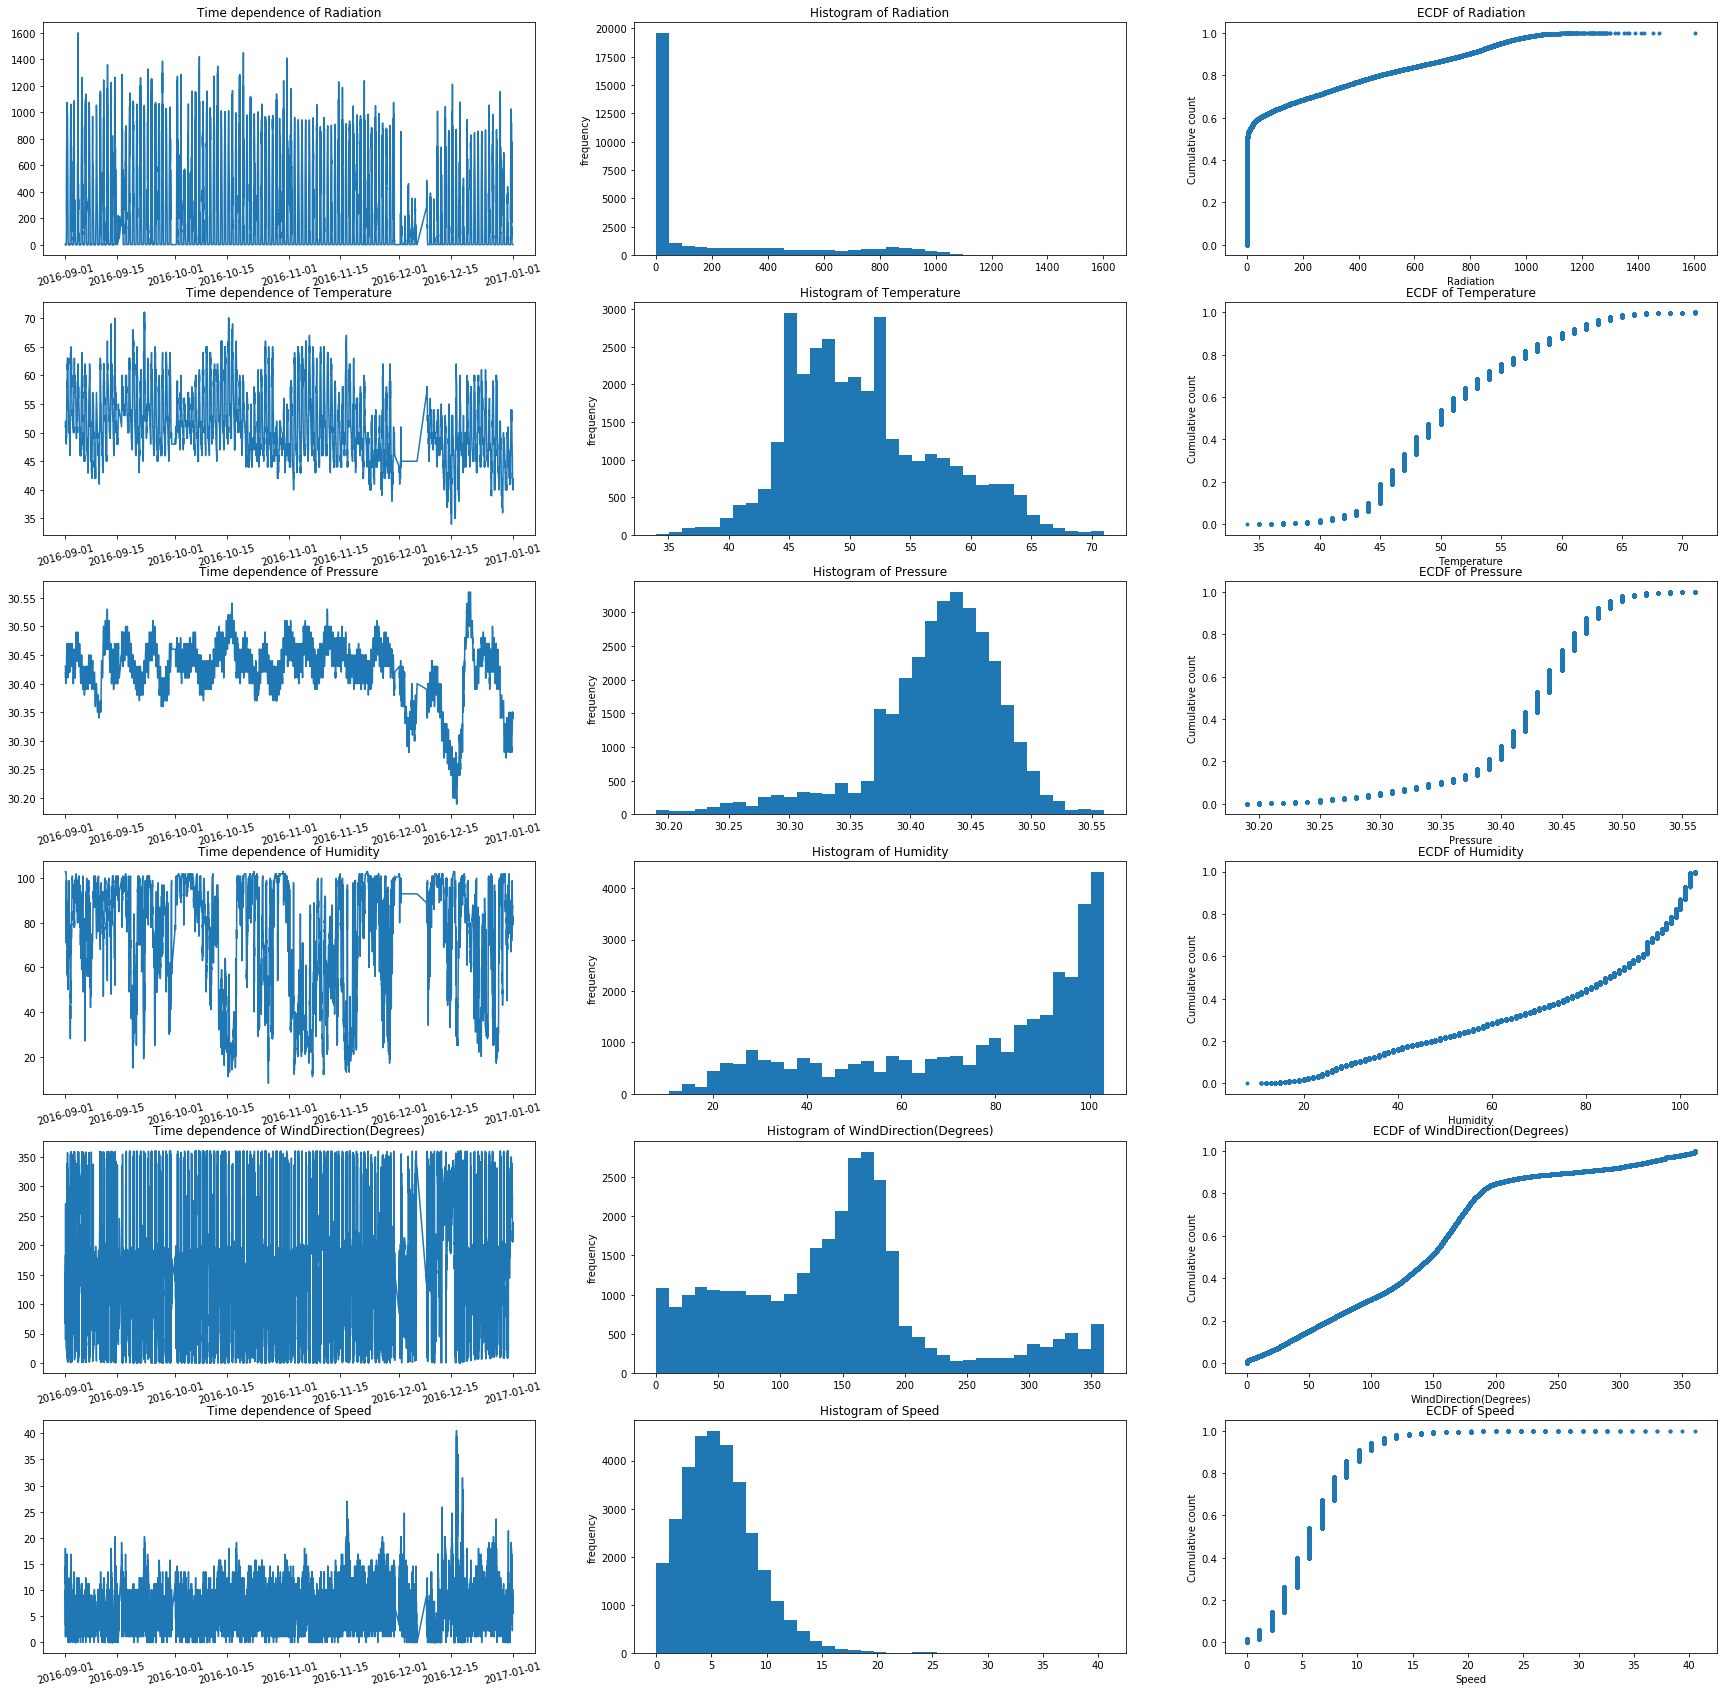

In [16]:
# Plot data characteristics, time dependancy, pdf, cdf
# Other than temperature, pretty much no feature looks gaussian

numeric_features = ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']
figures, axes = plt.subplots(6, 3, figsize=(30, 30))
for ax, feature in zip(axes.flat[::3], numeric_features):
    ax.plot(solar.index, solar[feature])
    ax.set_title(f'Time dependence of {feature}')
    ax.set_ylabel('')
    for tick in ax.get_xticklabels():
        tick.set_rotation(15)

for ax, feature in zip(axes.flat[1::3], numeric_features):
    ax.hist(solar[feature], bins=35)
    ax.set_title(f'Histogram of {feature}')
    ax.set_ylabel('frequency')
    
for ax, feature in zip(axes.flat[2::3], numeric_features):
    x = np.sort(solar[feature])
    y = np.arange(1, len(solar[feature]) + 1) / len(solar[feature])
    ax.plot(x, y, marker='.', linestyle='none')
    ax.set_title(f'ECDF of {feature}')
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Cumulative count')

In [17]:
# solar_15min = solar.resample('15min').mean().interpolate()
# solar_15min.head()

In [18]:
# adf test for stationarity suggests stationarity despite wild plots
print(adfuller(solar['Radiation']))
print(adfuller(solar['Radiation'].diff().dropna()))

(-23.773592416137294, 0.0, 45, 32640, {'1%': -3.4305503619592987, '5%': -2.8616285548332026, '10%': -2.5668171349895847}, 378226.11686987226)
(-23.727897503308565, 0.0, 52, 32632, {'1%': -3.430550411083526, '5%': -2.8616285765441147, '10%': -2.566817146545757}, 378730.6210966603)


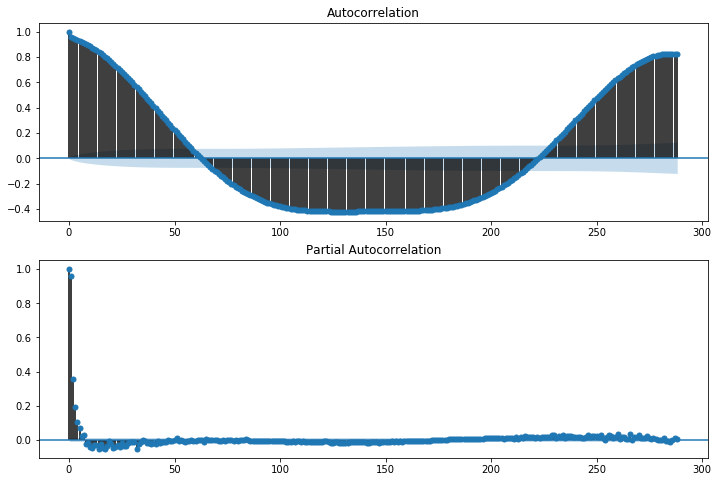

In [19]:
# Clear seasonality based on time of the day
lags = 288 # About 288 5min intervals in a day 

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
plot_acf(solar['Radiation'], lags=lags, ax=ax1)

plot_pacf(solar['Radiation'], lags=lags, ax=ax2)

plt.show()

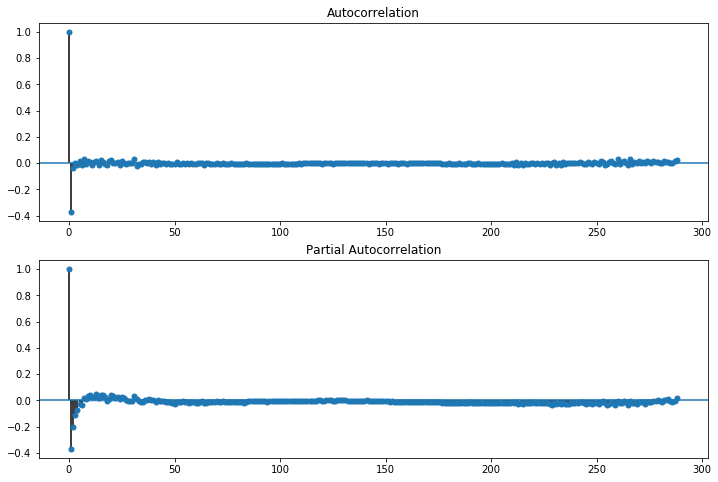

In [20]:
# 1st order diff look much more stationary
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
plot_acf(solar['Radiation'].diff().dropna(), lags=lags, ax=ax1)

plot_pacf(solar['Radiation'].diff().dropna(), lags=lags, ax=ax2)

plt.show()

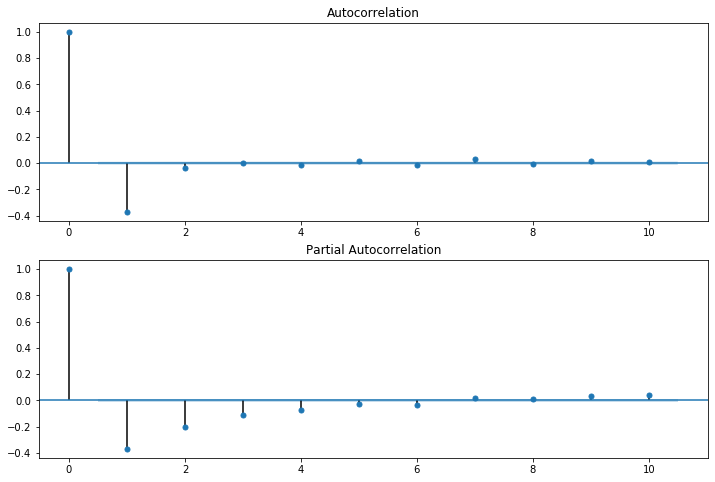

In [21]:
# 1st order diff closeup looks fine too, eyeballing it suggests MA of 1
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
plot_acf(solar['Radiation'].diff().dropna(), lags=10, ax=ax1)

plot_pacf(solar['Radiation'].diff().dropna(), lags=10, ax=ax2)

plt.show()

### Overall, the most important variables seem to be autocorrelation(with diff) and temperature.

## Modelling with ARIMA models

### Univariate

/home/kayes/anaconda3/envs/solar-radiation/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/kayes/anaconda3/envs/solar-radiation/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


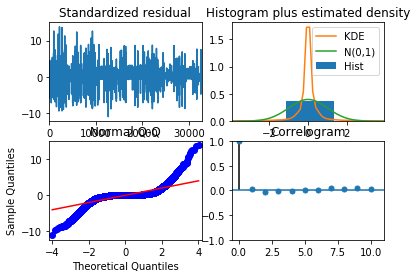

In [22]:
arima = SARIMAX(solar['Radiation'], order=(0, 1, 1)) # seasonal_order
model = arima.fit() # results.summary()

# Residuals are highly centred ... clearly not gaussian
model.plot_diagnostics()
plt.show()

In [23]:
prediction_start = -500
view_start = -1000

observed = solar['Radiation'].values[view_start:]
observed_index = solar.index[view_start:]

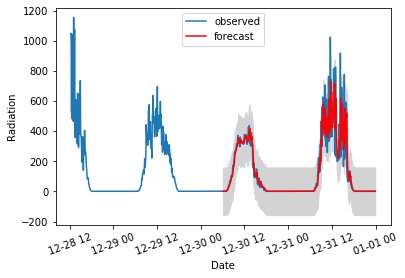

RMSE: 87.42999341010616


In [24]:
# Univariate step forecasting actually does well
one_step_forecast = model.get_prediction(start=prediction_start)
mean_forecast = one_step_forecast.predicted_mean
confidence_intervals = one_step_forecast.conf_int()
lower_limits = confidence_intervals['lower Radiation']
upper_limits = confidence_intervals['upper Radiation']
rmse = np.sqrt(mean_squared_error(solar['Radiation'].values[prediction_start:], mean_forecast))

plt.plot(observed_index, observed, label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='lightgray')

plt.xlabel('Date')
plt.ylabel('Radiation')
plt.xticks(rotation=20)
plt.legend()
plt.show()
print(f'RMSE: {rmse}')

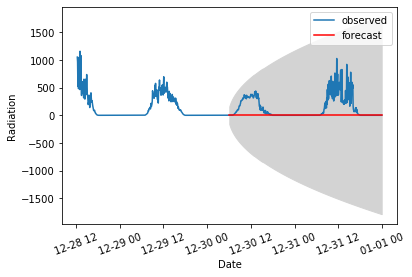

RMSE: 232.98054876662385


In [25]:
# But trying to predict further into the future depends largely on starting point
dynamic_forecast = model.get_prediction(start=prediction_start, dynamic=True)
mean_forecast = dynamic_forecast.predicted_mean
confidence_intervals = dynamic_forecast.conf_int()
lower_limits = confidence_intervals['lower Radiation']
upper_limits = confidence_intervals['upper Radiation']
rmse = np.sqrt(mean_squared_error(solar['Radiation'].values[prediction_start:], mean_forecast))

plt.plot(observed_index, observed, label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='lightgray')

plt.xlabel('Date')
plt.ylabel('Radiation')
plt.xticks(rotation=20)
plt.legend()
plt.show()
print(f'RMSE: {rmse}')

### Including temperature as a variable would help mitigate the dependency on starting value

/home/kayes/anaconda3/envs/solar-radiation/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/kayes/anaconda3/envs/solar-radiation/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


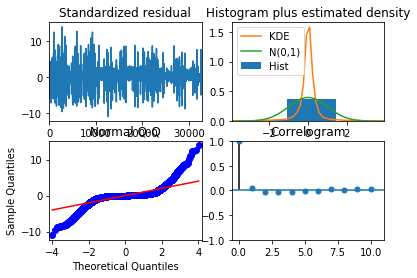

In [26]:
arima = SARIMAX(solar['Radiation'], order=(0, 1, 1), exog=solar['Temperature']) # seasonal_order
model = arima.fit() # results.summary()

model.plot_diagnostics()
plt.show()

In [27]:
prediction_start = -500
view_start = -1000

observed = solar['Radiation'].values[view_start:]
observed_index = solar.index[view_start:]

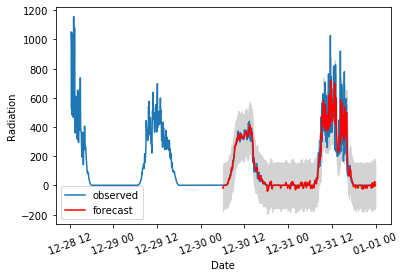

RMSE: 86.93684615602602


In [28]:
one_step_forecast = model.get_prediction(start=prediction_start)
mean_forecast = one_step_forecast.predicted_mean
confidence_intervals = one_step_forecast.conf_int()
lower_limits = confidence_intervals['lower Radiation']
upper_limits = confidence_intervals['upper Radiation']
rmse = np.sqrt(mean_squared_error(solar['Radiation'].values[prediction_start:], mean_forecast))

plt.plot(observed_index, observed, label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='lightgray')

plt.xlabel('Date')
plt.ylabel('Radiation')
plt.xticks(rotation=20)
plt.legend()
plt.show()
print(f'RMSE: {rmse}')

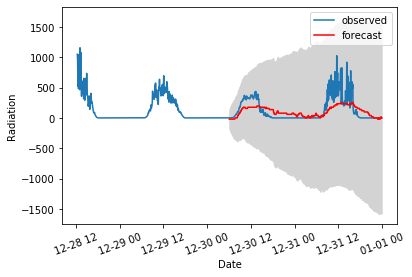

RMSE: 149.5571795999796


In [29]:
one_step_forecast = model.get_prediction(start=prediction_start, dynamic=True)
mean_forecast = one_step_forecast.predicted_mean
confidence_intervals = one_step_forecast.conf_int()
lower_limits = confidence_intervals['lower Radiation']
upper_limits = confidence_intervals['upper Radiation']
rmse = np.sqrt(mean_squared_error(solar['Radiation'].values[prediction_start:], mean_forecast))

plt.plot(observed_index, observed, label='observed')
plt.plot(mean_forecast.index, mean_forecast.values, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='lightgray')

plt.xlabel('Date')
plt.ylabel('Radiation')
plt.xticks(rotation=20)
plt.legend()
plt.show()
print(f'RMSE: {rmse}')

### Overall, ARIMA with time difference of order 1 and moving average order 1 can capture the short term trends well, but the use of temperature helps to better capture immediate effects
### Next, I will look into how to model seasonality after learning how it works.